In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import math
import pandas as pd
import xgboost
import lightgbm
import catboost

from matplotlib.colors import ListedColormap
from scipy.stats import pearsonr
from itertools import combinations
from sklearn.base import BaseEstimator
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (RandomForestClassifier,
                              ExtraTreesClassifier,
                              VotingClassifier)
from sklearn.tree import (DecisionTreeRegressor,
                          DecisionTreeClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, accuracy_score

In [2]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Bias-variance trade-off

**2 балла**

Продемонстрируйте bias-variance trade-off для `DecisionTreeRegressor` при изменении глубины дерева. Постройте регрессионную модель функции от одной независимой переменной, представленной в ячейке ниже, используя функцию `plot_regression_predictions` (можете ее как-то поменять, если захочется). Попробуйте разные значения глубины деревьев, при каком значении, на ваш взгляд, модель оптимальна, при каком variance становится слишком большим?

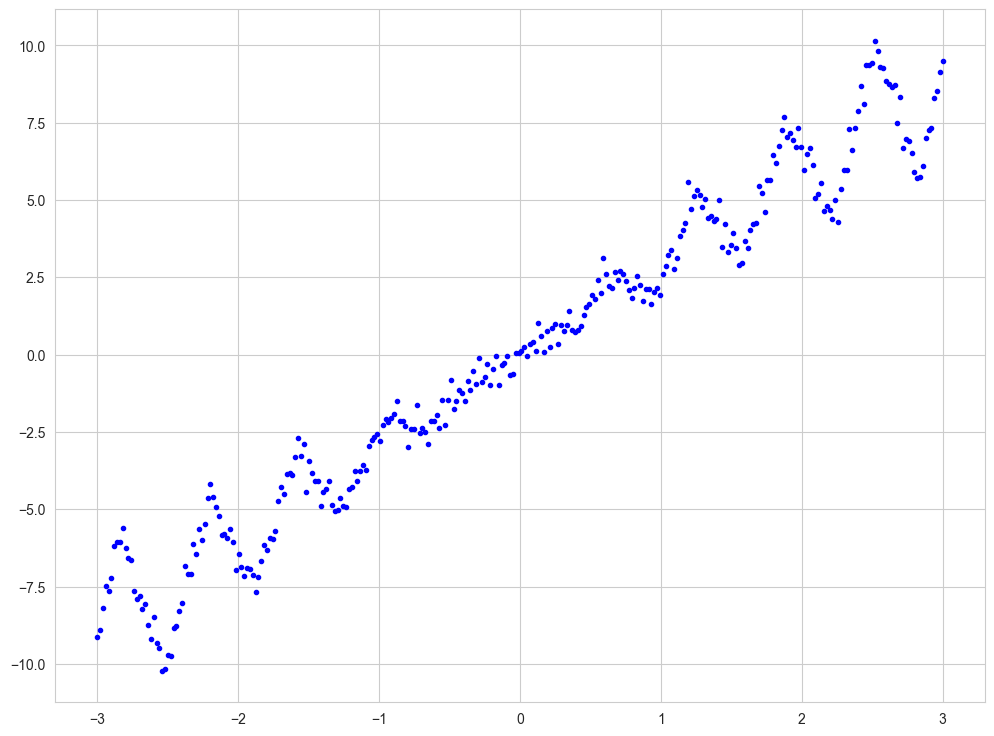

In [3]:
# Сгенерируем какую-нибудь необычную зависимость и научимся ее предсказывать
np.random.seed(42)
m = 300
X = np.linspace(-3, 3, m).reshape(-1, 1)
y = (3 + 2/np.pi * np.arcsin(np.cos(10 * X))) * X
y = y + np.random.randn(m, 1) / 3
plt.plot(X.reshape(-1), y.reshape(-1), "b.");

In [4]:
# Функция для отрисовки предсказаний деревьев решений в случае регрессии
def plot_regression_predictions(tree_reg, X, y, axes=[-3, 3, -10, 10], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)

    plt.plot(x1, y_pred, linewidth=2, label=r"$\hat{y}$")

Изобразите, как меняются предсказания дерева при увеличении максимальной глубины (можно взять что-то в диапазоне от 1 до 15):

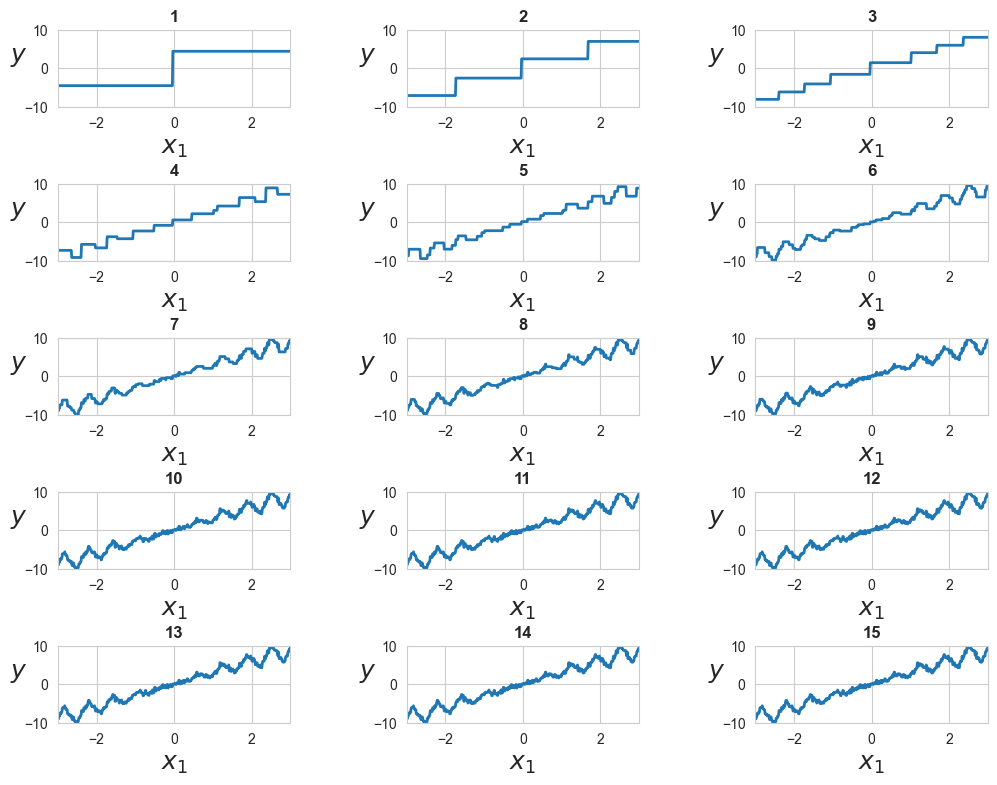

In [5]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

for i in range(1, 16):
    plt.subplot(5, 3, i)
    regr = DecisionTreeRegressor(max_depth=i)
    regr.fit(X, y)
    plot_regression_predictions(regr, X, y)
    plt.title(i, fontweight="bold")

plt.subplots_adjust(wspace=0.5, hspace=1)

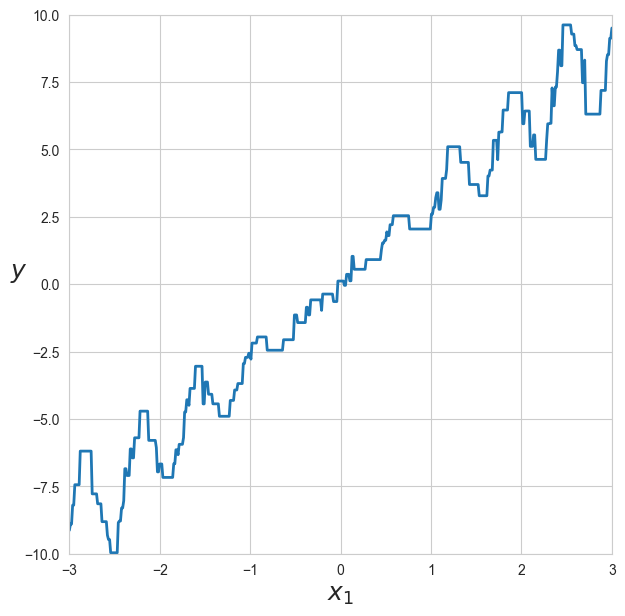

In [6]:
# Картина при глубине дерева равной 7

plt.figure(figsize=(7, 7))
regr = DecisionTreeRegressor(max_depth=7)
regr.fit(X, y)
plot_regression_predictions(regr, X, y)

**Вывод**
- При глубине дерева 6-7, в целом, модель начинает отражать основные тенденции в представленных данных.
- Начиная с глубины 8 увеличивается количество пиков в области центральной области. Выглядит, что такие показатели гиперпараметров уже приводят к переобучению модели.

### Задание 2. Random forest

Теперь давайте немного подготовимся к тому, чтобы реализовать свой собственный случайный лес, а потом реализуем его.

#### Задание 2. 1. Простое ансамблирование

**1 балла**

Представим, что у нас есть 101 классификатор. Каждый может с вероятностью `p` (равной для всех моделей) правильно предсказать класс объекта. Будем делать предсказания по большинству голосов (majority vote). Постройте зависимость вероятности правильно классифицировать объект от значения `p`. Вам может быть полезная следующая формула:

$$ \large \mu = \sum_ {i = 51} ^ {101} C_{101} ^ ip ^ i (1-p) ^ {101-i} $$

In [7]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

In [8]:
# Создаем вектор разных вероятностей
p = np.arange(0, 1.01, 0.01)

# Определяем mu и готовим вектор для добавления разных значений
mu = 0
mu_list = []

# Сначала считаем для каждого i
for i in range(51, 102):
    mu = (math.factorial(101)/(math.factorial(101-i) * math.factorial(i))) * p**i * (1 - p)**(101 - i)
    mu_list += [mu]
    
mu_array = np.array(mu_list)
# Суммируем значения для каждой вероятности
result = np.sum(mu_array, axis=0)

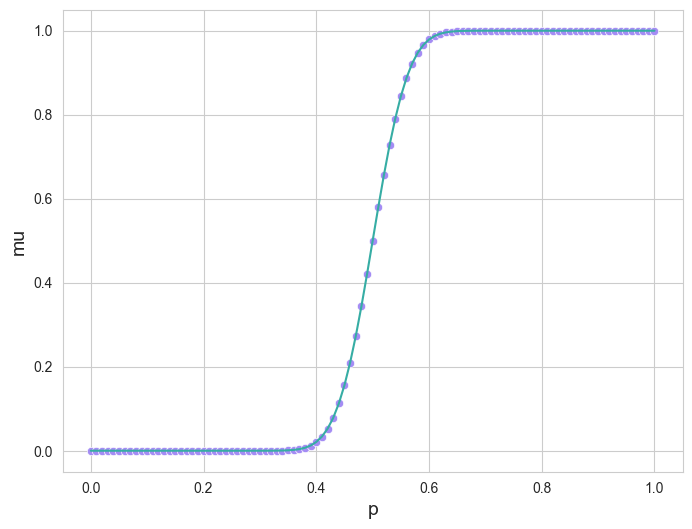

In [9]:
# Визуализируем

plt.figure(figsize=(8, 6))
sns.lineplot(y=result, x=p, color=sns.color_palette("husl", 8)[4])
sns.scatterplot(y=result, x=p, color=sns.color_palette("husl", 8)[6])
plt.ylabel('mu', fontsize=14)
plt.xlabel('p', fontsize=14);

А теперь давайте посмотрим на другую ситуацию. У нас есть фиксированная вероятность того, что модель правильно классифицирует объект `p = 0.65`. Постройте зависимость вероятности правильно классифицировать объект от числа моделей в ансамбле.

In [10]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

In [11]:
# Определяем значение вероятности 
p = 0.65

# Создаем две коллекции со значениями mu и количеством классификаторов
mu = 0
mu_list = []
whole_mu_list = []
number_list = []
# В данном случае мы добавляем итерацию по верхней границе, чтобы работать с разным количеством моделей
for j in range(100, -1, -1):
    for i in range (1, 102 - j):
        max_number = 102 - j - 1
        mu = (math.factorial(max_number)/(math.factorial(max_number-i) * math.factorial(i))) * p**i * (1 - p)**(max_number - i)
        mu_list += [mu]
    number_list += [max_number]
    whole_mu_list += [(np.sum(mu_list))]
    mu_list = []

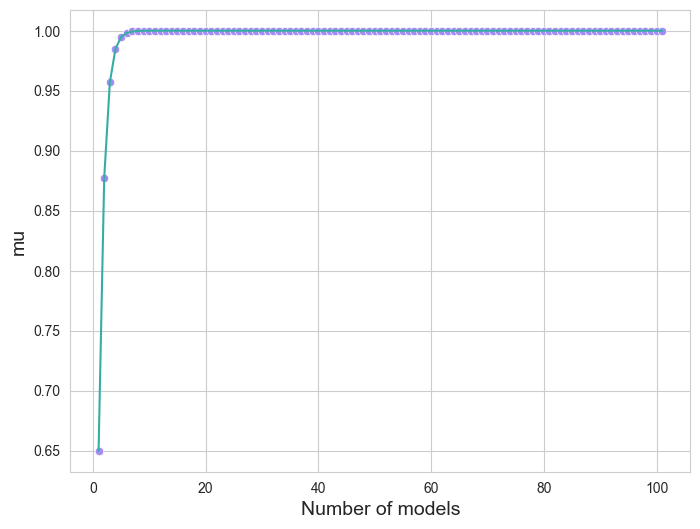

In [12]:
# Визуализируем 

plt.figure(figsize=(8, 6))
sns.lineplot(y=whole_mu_list, x=number_list, color=sns.color_palette("husl", 8)[4])
sns.scatterplot(y=whole_mu_list, x=number_list, color=sns.color_palette("husl", 8)[6])
plt.ylabel('mu', fontsize=14)
plt.xlabel('Number of models', fontsize=14);

Опишите ваши наблюдения:

* Вероятность правильно классифицировать объект напрямую зависит от p каждой модели и их общего количества, в целом.
* По значениям p (равной для каждой модели) мы можем предсказать вероятность правильно классифицировать в ансамбле. Единственная поправка, в последнем случае значения вероятности занимают более крайние значения.
* Если p равно 0.65, то уже при количестве моделей в районе 10 вероятность правильно классифицировать объект приближается к 1.

#### Задание 2. 2. Реализация простого RF

**4 балла**

Реализуйте свой собственный класс `RandomForestClassifierCustom`, используя в качестве базовой модели `DecisionTreeClassifier` из `sklearn`.

Небольшое описание:
- Используйте приведенный ниже код
- В методе `fit` в цикле (`i` от 0 до `n_estimators-1`):
    * Зафиксируйте генератор случайных чисел следующим образом np.random.seed(`random_state + i`). Идея в том, что на каждой итерации у нас будет новое значение для генератора случайных чисел, что добавит побольше "случайности", но в то же время мы сможем иметь воспроизводимые результаты
    * После чего выберите `max_features` признаков **без возвращения/without replacement**, сохраните список выбранных признаков (их индексов) в `self.feat_ids_by_tree`
    * Также создайте псевдовыборку при помощи бутстрэпа (выбор **с возвращением/with replacement**) из тренировочных данных. Может помочь функция `np.random.choice` и ее аргумент `replace`
    * Обучите дерево решений с параметрами, заданными в конструкторе класса `max_depth`, `max_features` и `random_state` на полученной псевдовыборке.
- Метод `fit` должен возвращать текущий экземпляр класса `RandomForestClassifierCustom`, то есть `self` (все по-взрослому, как в `sklearn`)
- В методе `predict_proba` мы должны пройти циклом по всем деревьям. Для каждого предсказания, нам нужно будет брать только те признаки, на которых училось изначальное дерево, поэтому мы и сохраняли эту информацию в артрибуте `self.feat_ids_by_tree`. Этот метод должен возвращать предсказанные вероятности (можно делать двумя способами: для каждого дерева предсказывать значение при помощи метода `predict_proba` и потом усреднять эти вероятности, или к примеру пользоваться методом `predict` и также считать среднее.

In [13]:
class RandomForestClassifierCustom(BaseEstimator):
    def __init__(
        self, n_estimators=10, max_depth=None, max_features=None, random_state=SEED
    ):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state

        self.trees = []
        self.feat_ids_by_tree = []

    def fit(self, X, y):
        self.classes_ = sorted(np.unique(y))
        
        ## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
        for i in range(self.n_estimators):
            np.random.seed(seed=self.random_state + i)
            rand_features = np.random.choice(X.shape[1], self.max_features, replace=False)
            self.feat_ids_by_tree += [rand_features]
            # Будем случайно отбирать половину выборки 
            rand_samples = np.random.choice(X.shape[0], X.shape[0] // 2, replace=True)
            X_sample = X[rand_samples][:, rand_features]
            y_sample = y[rand_samples]
            clf = DecisionTreeClassifier(max_depth=self.max_depth, 
                                         max_features=self.max_features, 
                                         random_state=self.random_state)
            clf.fit(X_sample, y_sample)
            self.trees += [clf]
        return self

    def predict_proba(self, X):
        ## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
        predict_proba_list = []
        number_tree = 0
        for tree in self.trees:
            prediction = tree.predict_proba(X[:, self.feat_ids_by_tree[number_tree]])
            predict_proba_list += [prediction]
            number_tree += 1
        return np.array(predict_proba_list).mean(axis=0)
    
    def predict(self, X):
        probas = self.predict_proba(X)
        predictions = np.argmax(probas, axis=1)
        
        return predictions

Протестируем нашу реализацию на искусственных данных. Визуализируйте разделяющую границу, которую рисует ваша модель при помощи функции `plot_decision_boundary` (см. примеры в лекции).

In [14]:
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    print(X_new.shape)
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(["#ffdab9","#9898ff", "#4B0082"])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(["#ffdab9", "#4c4c7f", "#4B0082"])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

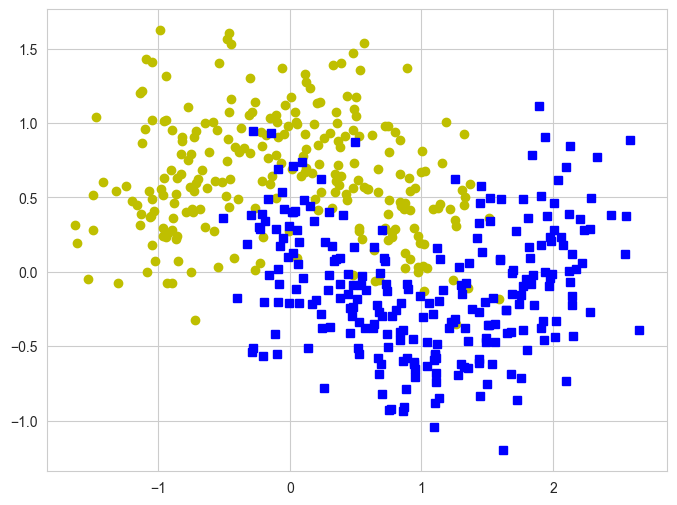

In [15]:
X, y = datasets.make_moons(n_samples=500, noise=0.30, random_state=SEED)

plt.figure(figsize=(8, 6))
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.show()

In [16]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

In [17]:
X.shape

(500, 2)

У нас всего 2 признака в данных, поэтому с них и начнем. Глубину деревьев поставим 15

(10000, 2)


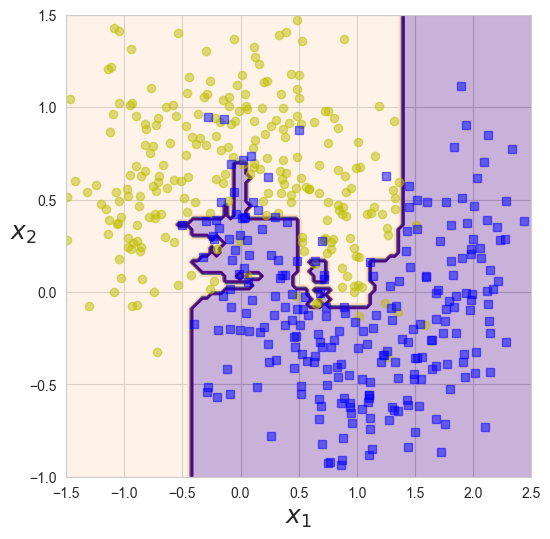

In [18]:
rf_clf = RandomForestClassifierCustom(max_depth=15, max_features=2, random_state=SEED)
rf_clf.fit(X, y)
plt.figure(figsize=(6, 6))
plot_decision_boundary(rf_clf, X, y)

In [19]:
# Полученное значение roc_auc
roc_auc_score(y, rf_clf.predict(X))

0.962

Ради интереса отберем только 1 признак в нашей модели 

(10000, 2)


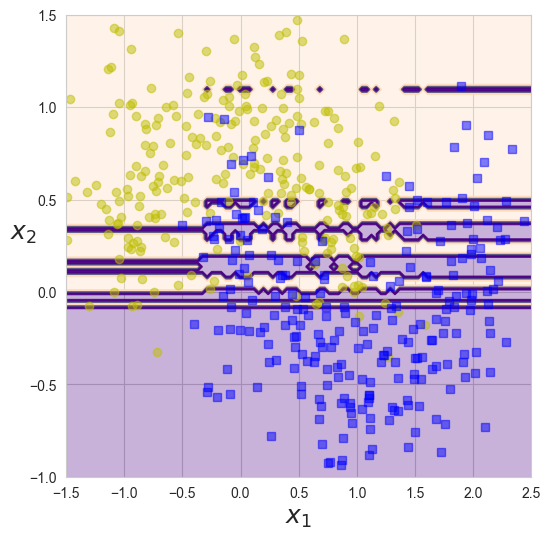

In [20]:
rf_clf_1 = RandomForestClassifierCustom(max_depth=15, max_features=1, random_state=SEED)
rf_clf_1.fit(X, y)
plt.figure(figsize=(6, 6))
plot_decision_boundary(rf_clf_1, X, y)

In [21]:
# Полученные roc_auc_score
roc_auc_score(y, rf_clf_1.predict(X))

0.942

**Вывод**

Получается не очень красивая картина. 
В последующем анализе буду подбирать только глубину деревьев и количество моделей. Количество признаков оставлю на уровне 2 

Подберите наилучшие гиперпараметры, при которых разделяющая граница будет, на ваш взгляд, оптимальной с точки зрения bias-variance. Можно также подключить какие-то метрики для выбора лучшей модели.

In [22]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

In [23]:
# Разделяем выборку на тестовую и треноровочную

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=SEED)

In [24]:
# Отбираем разные показатели глубины и кол-ва моделей

model_choice = pd.DataFrame({'n_estimators': [], 
                             'max_depth': [], 
                             'roc_auc_score': []})
for n_estimator in range(1, 51):
    for max_depth_score in range(2, 31):
        rf_clf = RandomForestClassifierCustom(n_estimators=n_estimator,
                                              max_depth=max_depth_score, 
                                              max_features=2, 
                                              random_state=SEED)
        rf_clf.fit(X_train, y_train)
        roc_auc = roc_auc_score(y_test, rf_clf.predict(X_test))
        result = pd.DataFrame({'n_estimators': [n_estimator], 
                             'max_depth': [max_depth_score], 
                             'roc_auc_score': [roc_auc]})
        model_choice = pd.concat([model_choice, result])

In [25]:
# Посмотрим, при каких значениях достигается 
model_choice[model_choice['roc_auc_score'] == model_choice['roc_auc_score'].max()]

,n_estimators,max_depth,roc_auc_score
0,38.0,4.0,0.937179
0,39.0,4.0,0.937179
0,40.0,4.0,0.937179
0,41.0,4.0,0.937179
0,42.0,4.0,0.937179


В целом, мы видим, что при 38 использованных моделях и глубине деревьев 4 мы достигаем максимальных значений roc_auc. При этом уже на данном примере видно, что на качество модели больше влияет количество моделей, чем глубина деревьев

(10000, 2)
(10000, 2)


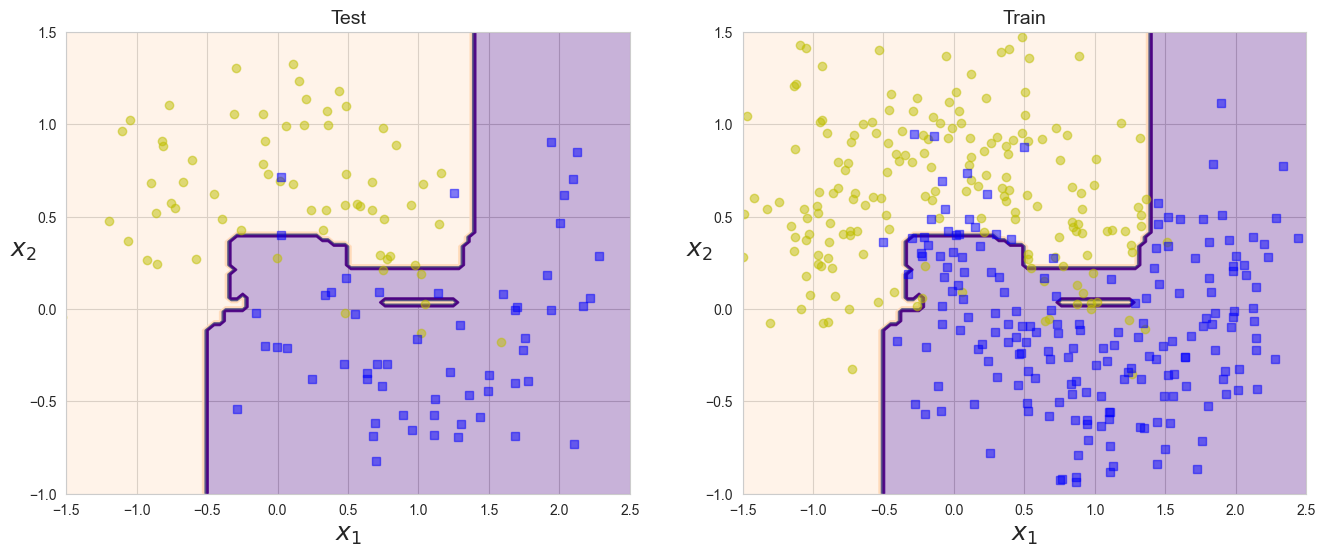

In [26]:
# Визуализируем полученные результаты 

rf_clf_2 = RandomForestClassifierCustom(n_estimators=38, max_depth=4, max_features=2, random_state=SEED)
rf_clf_2.fit(X_train, y_train)

plt.figure(figsize=(16, 6))
plt.subplot(121)
plot_decision_boundary(rf_clf_2, X_test, y_test)
plt.title("Test", fontsize=14)
plt.subplot(122)
plot_decision_boundary(rf_clf_2, X_train, y_train)
plt.title("Train", fontsize=14)
plt.show()

В целом, выглядит неплохо. Variance в данном случае точно победили. Тут уже остался под вопросом только bias.

Попробую проанализировать качество моделей с использованием **accuracy**

In [27]:
# Отбираем разные показатели глубины и кол-ва моделей

model_choice_acc = pd.DataFrame({'n_estimators': [], 
                             'max_depth': [], 
                             'accuracy': []})
for n_estimator in range(1, 51):
    for max_depth_score in range(2, 31):
        rf_clf = RandomForestClassifierCustom(n_estimators=n_estimator,
                                              max_depth=max_depth_score, 
                                              max_features=2, 
                                              random_state=SEED)
        rf_clf.fit(X_train, y_train)
        accuracy = accuracy_score(y_test, rf_clf.predict(X_test))
        result = pd.DataFrame({'n_estimators': [n_estimator], 
                             'max_depth': [max_depth_score], 
                             'accuracy': [accuracy]})
        model_choice_acc = pd.concat([model_choice_acc, result])

In [28]:
# Отбираем модели с наибольшим значением accuracy

model_choice_acc[model_choice_acc['accuracy'] == model_choice_acc['accuracy'].max()].head()

,n_estimators,max_depth,accuracy
0,9.0,5.0,0.936
0,18.0,5.0,0.936
0,19.0,5.0,0.936
0,20.0,5.0,0.936
0,20.0,6.0,0.936


В данном случае наилучшие показатели у модели с 9 моделями и глубиной 5

(10000, 2)
(10000, 2)


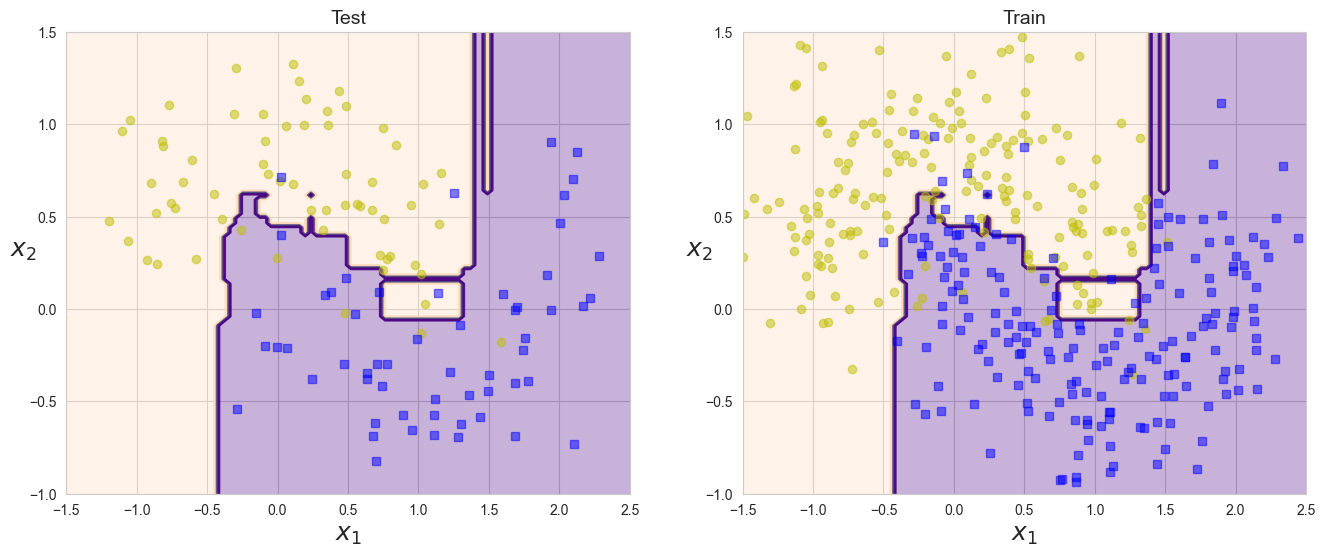

In [29]:
# Визуализируем полученную модель

rf_clf_3 = RandomForestClassifierCustom(n_estimators=9, max_depth=5, max_features=2, random_state=SEED)
rf_clf_3.fit(X_train, y_train)

plt.figure(figsize=(16, 6))
plt.subplot(121)
plot_decision_boundary(rf_clf_3, X_test, y_test)
plt.title("Test", fontsize=14)

plt.subplot(122)
plot_decision_boundary(rf_clf_3, X_train, y_train)
plt.title("Train", fontsize=14)
plt.show()

На мой взгляд эта модель все еще переобучена. 

В нашем списке наилучших моделей по accuracy был ансамбль, включающий 18 моделей и глубину 5. Попробуем построить её.

(10000, 2)
(10000, 2)


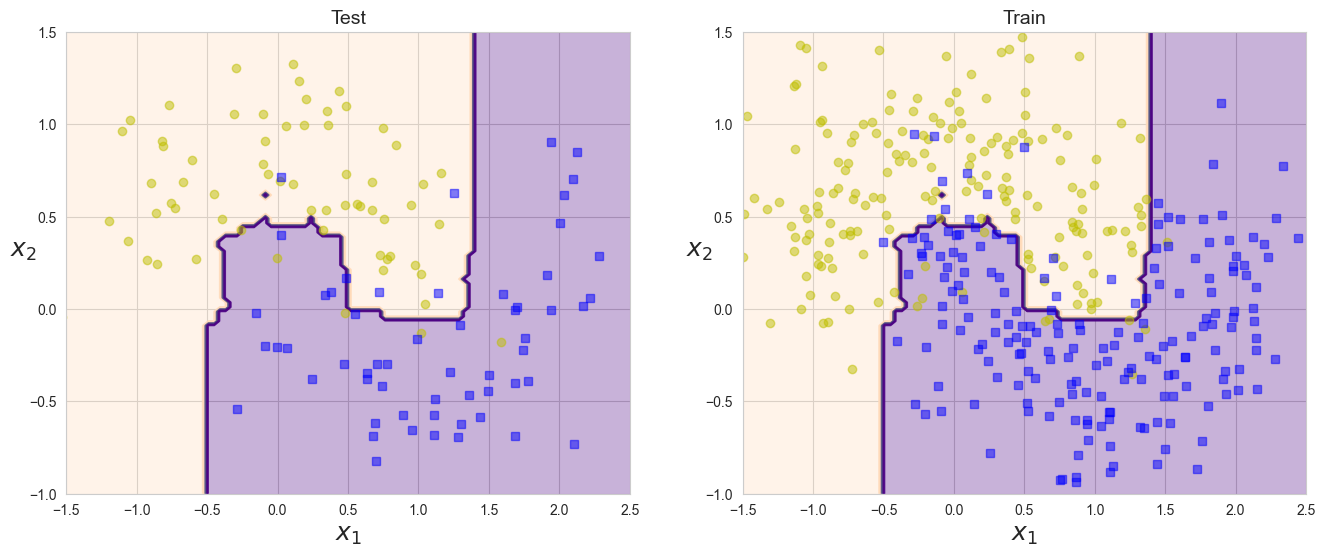

In [30]:
# Визуализируем полученные результаты

rf_clf_4 = RandomForestClassifierCustom(n_estimators=18, max_depth=5, max_features=2, random_state=SEED)
rf_clf_4.fit(X_train, y_train)

plt.figure(figsize=(16, 6))
plt.subplot(121)
plot_decision_boundary(rf_clf_4, X_test, y_test)
plt.title("Test", fontsize=14)

plt.subplot(122)
plot_decision_boundary(rf_clf_4, X_train, y_train)
plt.title("Train", fontsize=14)
plt.show()

In [31]:
# У данной модели также высокий roc_auc

roc_auc_score(y_test, rf_clf_4.predict(X_test))

0.9358974358974359

**Вывод**

На мой взгляд наилучшими показателями обладает ансамбль, включающий 18 моделей, глубину деревьев 5 и кол-вом признаков - 2. Данная модель имеет наиболее четкое разделение двух категорий, при этом с минимумом признаков переобучения. 

#### Задание 2. 3. Корреляция базовых моделей

**3 балла**

Как мы выянили на лекции, для того, чтобы bagging работал хорошо, предсказания наших моделей не должны сильно коррелировать. Для этого в случайном лесе применяются различные подходы, в том числе и RSM. Давайте посмотрим, как влияет параметр `max_features` на корреляцию базовых моделей в случайном лесу из `sklearn`. В качестве примера будем использовать датасет `breast_cancer`. Для расчета корреляций используйте приведенную ниже функцию `base_model_pair_correlation`. Для каждой модели у вас будет получаться набор значений (попарные корреляции всех деревьев), дальше можно изобразить их в виде боксплотов, как мы на лекции рисовали распределение метрик.

In [32]:
# Функция для расчета попарных корреляций базовых моделей в случайном лесу
def base_model_pair_correlation(ensemble, X):
    corrs = []
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        ypred_t2 = est2.predict_proba(Xj_test)[:, 1]

        corrs.append(pearsonr(ypred_t1, ypred_t2)[0])
    return np.array(corrs)

In [33]:
# Загрузим данные
breast_cancer = datasets.load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [6]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

In [35]:
# Данный датасет содержит 30 различных признаков

X.shape

(569, 30)

In [67]:
# Набираем список с результатами корреляций моделей

cor_list = []
for max_feature in range(2, 31):
    scl_rf_clf = RandomForestClassifier(max_features=max_feature, random_state=SEED)
    scl_rf_clf.fit(X, y)
    cor = base_model_pair_correlation(scl_rf_clf, X)
    cor_list += [cor]

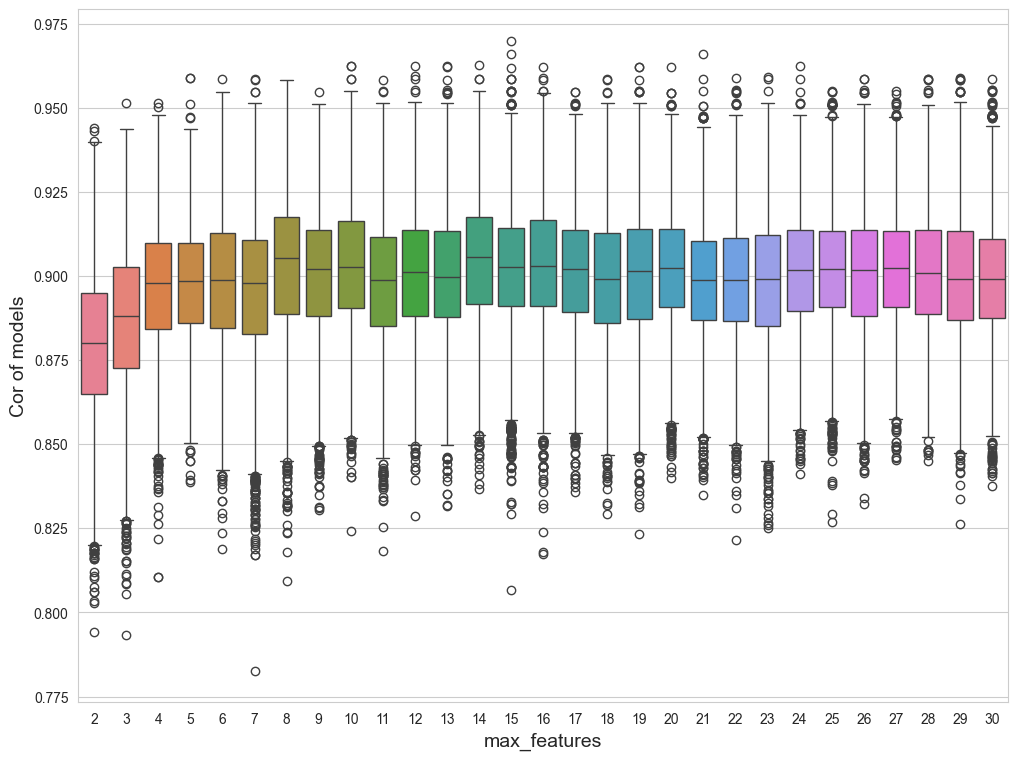

In [74]:
# Визуализируем полученные результаты 

sns.boxplot(cor_list)
plt.xticks(np.arange(29), list(range(2, 31)))
plt.ylabel('Cor of models', fontsize=14)
plt.xlabel('max_features', fontsize=14);

Теперь давайте посмотрим, как на это влияет параметр `max_depth`:

In [7]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

In [69]:
# Набираем список с результатами корреляций моделей

cor_list_depth = []
for max_depth_score in range(2, 31):
    scl_rf_clf = RandomForestClassifier(max_depth=max_depth_score, random_state=SEED)
    scl_rf_clf.fit(X, y)
    cor = base_model_pair_correlation(scl_rf_clf, X)
    cor_list_depth += [cor]

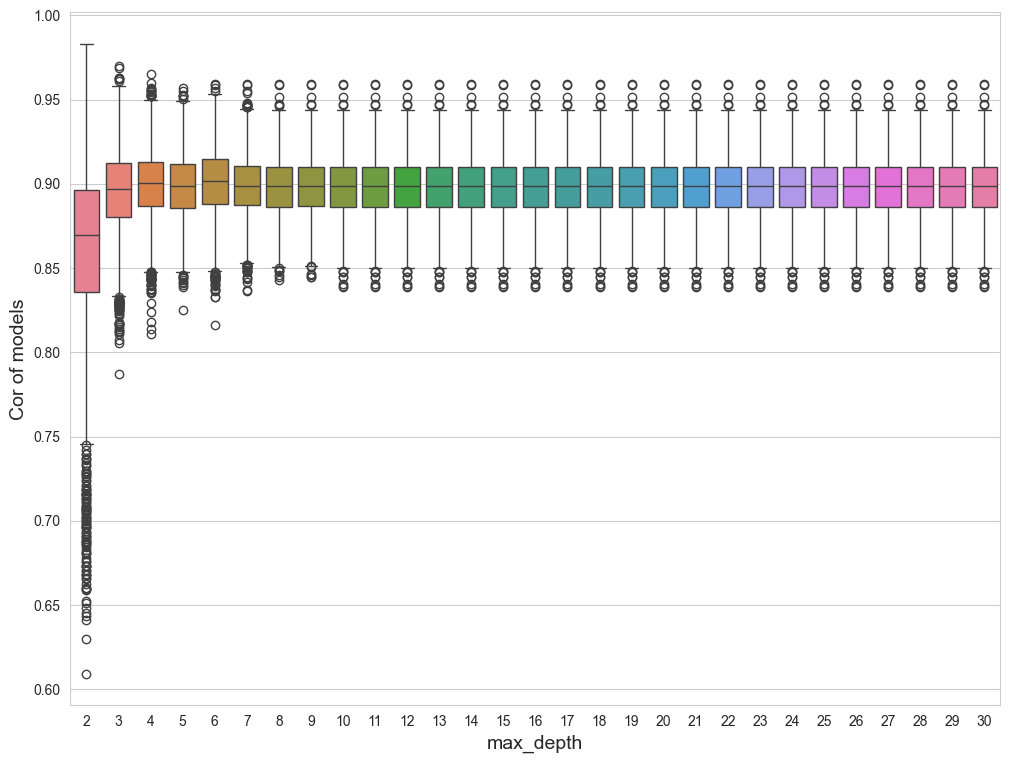

In [73]:
# Визуализируем полученные результаты 

sns.boxplot(cor_list_depth)
plt.xticks(np.arange(29), list(range(2, 31)))
plt.ylabel('Cor of models', fontsize=14)
plt.xlabel('max_depth', fontsize=14);

Опишите ваши наблюдения:

* С увеличением количества моделей степень корреляции между ними увеличивается. Однако с кол-ва моделей равном 5, в целом, показатель корреляции остается стабильным и измененяется в пределах совсем небольшого диапазона.
* С увеличением глубины деревьев также увеличивается корреляции. Однако, аналогично, с глубины равной 4-5 показатели корреляции выходят на плато и не меняются.

### Задание 3. Строим большой ансамбль

**4 балла + 3 дополнительных за скор выше 0.87**

В данной задаче вам нужно диагностировать сердечное заболевание у людей по медицинским показателям.

In [75]:
!gdown  --id 1VFbDK-Ad-hpf0_GGCBzn4thdn9mkQ-Y- -O heart.csv -q
heart_dataset = pd.read_csv("heart.csv")

zsh:1: command not found: gdown


FileNotFoundError: [Errno 2] No such file or directory: 'heart.csv'

In [114]:
X = heart_dataset.drop("target", axis=1)
y = heart_dataset["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)
X_train.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
178,43,1,0,120,177,0,0,120,1,2.5,1,0,3
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3
201,60,1,0,125,258,0,0,141,1,2.8,1,1,3
246,56,0,0,134,409,0,0,150,1,1.9,1,2,3
153,66,0,2,146,278,0,0,152,0,0.0,1,1,2


Обучите разнообразные классификаторы, приведенные ниже, а также ансамбль `VotingClassifier` из `sklearn.ensemble`, объединяющий эти классификаторы с помощью жесткого или мякого голосования (параметр `voting =` `'hard'` или `'soft'` соответственно). Оцените качество моделей с помощью кросс-валидации на тренировочном наборе, используя функцию `cross_val_score` и метрику `f1`. Часть моделей отсюда мы не проходили, о них можно почитать дополнительно, но в принципе для задания не очень важно знать принципы их работы (но, если есть время, то почитайте, там интересно).

In [118]:
dt = DecisionTreeClassifier(random_state=SEED, max_depth=10, min_samples_leaf=10)
rf = RandomForestClassifier(n_estimators=50, random_state=SEED)
etc = ExtraTreesClassifier(random_state=SEED)
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
svc_lin = SVC(kernel='linear', probability=True, random_state=SEED)
svc_rbf = SVC(kernel='rbf', probability=True, random_state=SEED)
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
lgbm = lightgbm.LGBMClassifier(random_state=SEED)
lgbm_rf = lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED)
xgb = xgboost.XGBClassifier(random_state=SEED)
xgb_rf = xgboost.XGBRFClassifier(random_state=SEED)
lr = LogisticRegression(solver='liblinear', max_iter=10000)
nb = GaussianNB()

base_models = [("DT", dt), ("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]

Здесь могут возникать различные предупреждения при обучении бустингов, не волнуйтесь, все нормально, просто они обычно очень разговорчивые)

In [8]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##



## END YOUR CODE HERE ##

for model in [dt, rf, cat, etc, knn, svc_lin, svc_rbf, xgb, lgbm, xgb_rf, lgbm_rf, lr, nb, voting_hard, voting_soft]: 
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
    print(f"{model.__class__.__name__}: {scores.mean()}")

Вы можете заметить, что ансамбль показывает хорошее, но не лучшее качество предсказания, попробуем его улучшить. Как вы знаете, ансамбли работают лучше, когда модели, входящие в них не скоррелированы друг с другом. Определите корреляцию предсказаний базовых моделей в ансамбле на тестовом наборе данных, и удалите из ансамбля те модели, чьи предсказания будут сильнее коррелировать с остальными. Воспользуйтесь функцией `base_model_pair_correlation_for_voting_clf`. **Спойлер**: далеко не факт, что если вы удалите две модели с корреляцией 0.95, то все станет сильно лучше, здесь все будет немного сложнее. Чтобы добиться максимального качества может понадобиться долгий перебор различных комбинаций моделей. Наилучший скор, который мне удалось достичь, это 0.915, но он получен весьма странной комбинацией алгоритмов, а еще и простым перебором всех вариантов)

In [127]:
def base_model_pair_correlation_for_voting_clf(ensemble, X):
    corrs = []
    base_model_names = [f"{est.__class__.__name__}" for est in ensemble.estimators_]
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        if not isinstance(est1, SVC):
            ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t1 = est1.decision_function(Xi_test)


        if not isinstance(est2, SVC):
            ypred_t2 = est2.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t2 = est2.decision_function(Xi_test)
        corrs.append((est1, est2, pearsonr(ypred_t1, ypred_t2)[0]))


    return corrs

In [9]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

### Задание 4. Определение оттока клиентов из телекома

**6 баллов + 7 дополнительных за высокое качество модели и различные эксперименты**

Будем предсказывать, уйдет ли от нас клиент (переменная `Churn?`). Данные можно скачать [здесь](https://www.kaggle.com/venky12347/churn-telecom). Это будет уже совсем взрослое задание, так как правильного ответа на него нет. Вам нужно будет разобраться с данными, правильно подготовить их для моделей, а также выбрать лучшую модель. 

Задача минимум:

Выберите 2 модели &mdash; один случайный лес и один бустинг из приведенных ниже:

1. `xgboost.XGBClassifier`
2. `xgboost.XGBRFClassifier` &mdash; случайный лес от xgboost
3. `lightgbm.LGBMClassifier`
4. `lightgbm.LGBMClassifier(boosting_type="rf")` &mdash; случайный лес от lightgbm
5. `catboost.CatBoostClassifier`

И попробуйте разобраться с тем, как для этих моделей правильно настраивать гиперпараметры. Советую гуглить примерно следующее `how to choose best hyperparameters for lightgbm`. Там вы найдете кучу сложного и непонятного кода, но если с ним разобраться и научиться обучать нестандартные бустинги, то в плане табличных данных равных вам не будет)

In [130]:
data = pd.read_csv("churn.csv")
data.head()

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


### Задание 5. Рисуем

**дополнительно 0.5 балла**

Наверняка, в процессе выполнения этого задания вас переполняли какие-то эмоции. Нарисуйте что-то, что бы могло бы передать их (я сам не умею, так что, если это будет просто квадрат, тоже подойдет). Прикрепите сюда свой рисунок:

In [ ]:
## PASTE YOUR MASTERPIECE HERE (/¯◡ ‿ ◡)/¯☆*##

### Therapy time

Напишите здесь ваши впечатления о задании (можно и не о задании): было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**